In [2]:
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
import pandas as pd
import numpy as np
import spacy
import sklearn
import pymorphy2
from pymorphy2 import MorphAnalyzer
import string
import re
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import matplotlib_inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
rus = "russian"
sw = stopwords.words(rus)
morph = MorphAnalyzer()
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
lancaster = LancasterStemmer()
snowball = SnowballStemmer(language=rus)
vectorizer = CountVectorizer()

c:\course_work\feature_extraction_NLP\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NitghtWay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NitghtWay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
train_path = 'C:\\course_work\\feature_extraction_NLP\\data\\test_ds1\\train.jsonl'
val_path = 'C:\\course_work\\feature_extraction_NLP\\data\\test_ds1\\val.jsonl'
train_data = pd.read_json(train_path, lines=True)
val_data = pd.read_json(val_path, lines=True)
df = pd.concat([train_data, val_data])
df = df.drop(['label', 'hypothesis', 'verb','negation'
,'idx','no_negation'], axis=1)
df.dropna()
df.head()


In [17]:
df['genre'] = df['genre'].replace('kp', 'interfax')

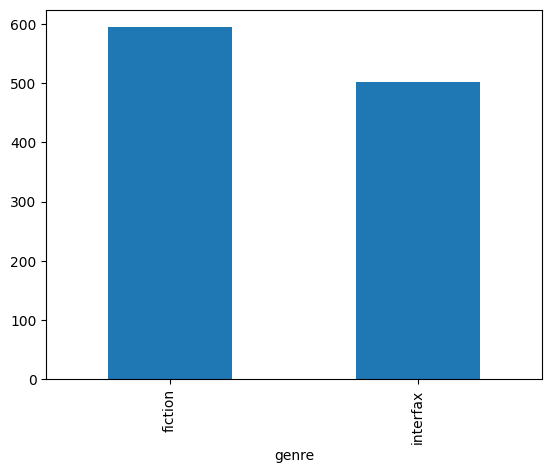

In [18]:
pivot_table = df.groupby('genre').size()
pivot_table.plot(kind='bar')
plt.show()

In [19]:
Y = pd.DataFrame({'genre':[str(genre) for genre in df['genre']]})
#Формирование наборов данных
df_morphy = pd.DataFrame({'text':[tokenize_morphy(sample) 
for sample in df['premise']]})
df_snowball = pd.DataFrame({'text':[tokenize_snowball(sample) 
for sample in df['premise']]})
df_lancaster = pd.DataFrame({'text':[tokenize_lancaster(sample) 
for sample in df['premise']]})
#Очистка от пустот
X1 = df_lancaster.dropna()
X2 = df_morphy.dropna()
X3 = df_snowball.dropna()

In [26]:
batch1 = X1.join(Y, how = 'right')
batch2 = X2.join(Y, how = 'right')
batch3 = X3.join(Y, how = 'right')

In [27]:
x_train, x_test, y_train, y_test = train_test_split(batch2['text'], batch2['genre'], test_size = 0.1, random_state = 45)

In [104]:
#BOW
vec = CountVectorizer(ngram_range=(1, 1))

bow = vec.fit_transform(x_train) 
bow_test = vec.transform(x_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     fiction       0.95      0.88      0.91        64
    interfax       0.84      0.93      0.89        46

    accuracy                           0.90       110
   macro avg       0.90      0.90      0.90       110
weighted avg       0.90      0.90      0.90       110



In [105]:
#Tf-idf
vec = TfidfVectorizer(ngram_range=(1, 1))
vec_train = vec.fit_transform(x_train)
vec_test = vec.transform(x_test)

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

     fiction       0.93      0.89      0.91        64
    interfax       0.86      0.91      0.88        46

    accuracy                           0.90       110
   macro avg       0.90      0.90      0.90       110
weighted avg       0.90      0.90      0.90       110



In [106]:
reverse_vocab = {value: key for key, value in vec.vocabulary_.items()}
reverse_vocab[np.argmax(clf.coef_)]

'подозревать'

Анализ посимвольный

In [107]:
train_path = 'C:\\course_work\\feature_extraction_NLP\\data\\test_ds1\\train.jsonl'
val_path = 'C:\\course_work\\feature_extraction_NLP\\data\\test_ds1\\val.jsonl'
train_data = pd.read_json(train_path, lines=True)
val_data = pd.read_json(val_path, lines=True)
df = pd.concat([train_data, val_data])
df = df.drop(['label', 'hypothesis', 'verb','negation'
,'idx','no_negation'], axis=1)
df['genre'] = df['genre'].replace('kp', 'interfax')

In [108]:
Y = pd.DataFrame({'genre':[str(genre) for genre in df['genre']]})
X = pd.DataFrame({'text': [text for text in df['premise']]})
x_train, x_test, y_train, y_test = train_test_split(X.text, Y.genre, random_state = 13)

In [131]:
x_train.head()

600    и человек вроде бы хороший мягкий артист немно...
76     каждый сам за себя жить вместе а с ум сходить ...
591    по он слово по мера укрепление партийный струк...
321    после стать я думать что говорить мама когда о...
487    за умышленный причинение тяжкий вред здоровье ...
Name: text, dtype: object

In [109]:
vec = CountVectorizer(ngram_range=(1, 1), analyzer="char")
bow = vec.fit_transform(x_train)
bow_test = vec.transform(x_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     fiction       0.87      0.91      0.89       137
    interfax       0.91      0.86      0.88       137

    accuracy                           0.89       274
   macro avg       0.89      0.89      0.89       274
weighted avg       0.89      0.89      0.89       274



In [110]:
reverse_vocab = {value: key for key, value in vec.vocabulary_.items()}
reverse_vocab[np.argmax(clf.coef_)]

'"'

Использование BERT, W2V, улучшение мешка слов и tf-idf

In [32]:
x_train, x_test, y_train, y_test = train_test_split(batch2['text'], batch2['genre'], test_size = 0.2, random_state = 45)
print(x_train.shape)
print(x_test.shape)

(876,)
(220,)


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 5, max_df = 1.0, ngram_range = (1, 1))
tfidf.fit(x_train)

TfidfVectorizer(min_df=5)

In [34]:
Xtrain = tfidf.transform(x_train)
Xtest = tfidf.transform(x_test)

Xtrain.shape, Xtest.shape

((876, 679), (220, 679))

In [35]:
lr_clf = LogisticRegression()
lr_clf.fit(Xtrain, y_train)

lr_train_pred = lr_clf.predict(Xtrain)
lr_test_pred = lr_clf.predict(Xtest)

In [36]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, lr_train_pred), accuracy_score(y_test, lr_test_pred)

(0.9257990867579908, 0.8818181818181818)

N-граммы

In [37]:
tfidf = TfidfVectorizer(min_df=5, max_df=1.0, ngram_range=(1, 2))
tfidf.fit(x_train)

TfidfVectorizer(min_df=5, ngram_range=(1, 2))

In [38]:
Xtrain = tfidf.transform(x_train)
Xtest = tfidf.transform(x_test)

Xtrain.shape, Xtest.shape

((876, 911), (220, 911))

In [39]:
lr_clf = LogisticRegression()
lr_clf.fit(Xtrain, y_train)

lr_train_pred = lr_clf.predict(Xtrain)
lr_test_pred = lr_clf.predict(Xtest)

accuracy_score(y_train, lr_train_pred), accuracy_score(y_test, lr_test_pred)

(0.932648401826484, 0.8863636363636364)

Word2vec

In [43]:
 X_train, X_test, y_train, y_test = train_test_split(batch2[['text']], batch2['genre'], test_size = 0.3, random_state = 45)
print(X_train.shape, type(X_train))
print(X_test.shape, type(X_test))

(767, 1) <class 'pandas.core.frame.DataFrame'>
(329, 1) <class 'pandas.core.frame.DataFrame'>


In [44]:
X_test.head()

,text
281,я посыпать голова пепел жениться хоть на стару...
63,мы по прежний исходить из тот что быть факт на...
5,для мама праздник быть как обычный день она ко...
256,снова появиться но уже с пепельница мочь челов...
1054,сосед по камера жестоко избить мигрант в ход н...


In [45]:
from gensim.models import Word2Vec
sent = [row.split() for row in X_train['text']]
print(sent)

[['мать', 'умерший', 'мужчина', 'тоже', 'подтвердить', 'что', 'девочка', 'она', 'внучка', 'кроме', 'тот', 'в', 'качество', 'доказательство', 'выступить', 'семейный', 'фотография', 'судить', 'по', 'который', 'отец', 'и', 'дочка', 'действительно', 'быть', 'близкий', 'в', 'результат', 'суд', 'официально', 'признать', 'мужчина', 'отец', 'свой', 'дочка'], ['плевать', 'на', 'всё', 'пойти', 'прямиком', 'к', 'она', 'позвонить', 'в', 'дверь', 'теперь', 'плевать', 'если', 'открыть', 'муж', 'или', 'сын', 'соврать', 'например', 'что', 'с', 'работа', 'попросить', 'она', 'выйти', 'на', 'пара', 'секунда'], ['он', 'ни', 'при', 'что', 'он', 'хороший', 'это', 'мама', 'так', 'не', 'вовремя', 'вот', 'вот', 'сказать', 'мать'], ['казаться', 'такой', 'мужчина', 'называться', 'брачный', 'аферист', 'бог', 'мой', 'что', 'я', 'делать', 'сказать', 'он', 'что', 'я', 'догадаться', 'о', 'обман', 'или', 'положить', 'бумажник', 'на', 'место', 'и', 'пока', 'притвориться', 'будто', 'я', 'не', 'в', 'курс', 'и', 'всё', 'п

In [46]:
HIDDEN = 100
model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=HIDDEN,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=2)
model.build_vocab(sent, progress_per=10000)
model.train(sent, total_examples=model.corpus_count, epochs=30, report_delay=1)

(27078, 625650)

In [47]:
#счет последнего вектора текста
def get_mean_w2v_vector(sentence):
    Sum = 0
    Count = 0

    try:
      words = sentence.split()
    except TypeError:
      words = []

    for w in words:
        if w in model.wv:
            Sum += model.wv[w]
            # Sum += glove_vectors[w]
            Count += 1

    if Count == 0:
        return 0

    return Sum / Count

In [48]:
NewCols = ['col'+str(i) for i in range(HIDDEN)]

X_train['vectors'] = X_train['text'].map(get_mean_w2v_vector)
X_test['vectors'] = X_test['text'].map(get_mean_w2v_vector)

X_train.head()

,text,vectors
994,мать умерший мужчина тоже подтвердить что дево...,"[0.060364537, 0.2743974, 0.09598439, -0.160116..."
1035,плевать на всё пойти прямиком к она позвонить ...,"[0.06286065, 0.27439573, 0.094334595, -0.16216..."
913,он ни при что он хороший это мама так не вовре...,"[0.055450518, 0.2744795, 0.09553656, -0.159733..."
91,казаться такой мужчина называться брачный афер...,"[0.05739004, 0.27555665, 0.09160974, -0.162238..."
943,есть смаковать каждый блюдо разговор и шутка у...,"[0.057878703, 0.2734555, 0.09467524, -0.166134..."


In [49]:
IdxTrain = []

for ix, row in X_train.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTrain.append(ix)

IdxTest = []

for ix, row in X_test.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTest.append(ix)

In [50]:
X_train.drop(index=IdxTrain, inplace=True)
X_test.drop(index=IdxTest, inplace=True)

y_train = y_train.drop(index=IdxTrain)
y_test = y_test.drop(index=IdxTest)

In [51]:
X_train[NewCols] = pd.DataFrame(X_train['vectors'].tolist(), index=X_train.index)
X_test[NewCols] = pd.DataFrame(X_test['vectors'].tolist(), index=X_test.index)

In [52]:
X_train.head()

,text,vectors,col0,col1,col2,col3,col4,col5,col6,col7,...,col90,col91,col92,col93,col94,col95,col96,col97,col98,col99
994,мать умерший мужчина тоже подтвердить что дево...,"[0.060364537, 0.2743974, 0.09598439, -0.160116...",0.060365,0.274397,0.095984,-0.160116,0.206304,-0.423733,0.234219,0.597312,...,0.166590,0.284469,0.053238,-0.081613,0.395229,0.057488,0.078757,-0.103357,-0.081062,-0.025863
1035,плевать на всё пойти прямиком к она позвонить ...,"[0.06286065, 0.27439573, 0.094334595, -0.16216...",0.062861,0.274396,0.094335,-0.162161,0.208021,-0.425759,0.234271,0.602052,...,0.166222,0.284497,0.051831,-0.079055,0.395174,0.057679,0.079572,-0.103842,-0.082142,-0.026175
913,он ни при что он хороший это мама так не вовре...,"[0.055450518, 0.2744795, 0.09553656, -0.159733...",0.055451,0.274480,0.095537,-0.159734,0.207887,-0.427775,0.237116,0.602570,...,0.163746,0.288197,0.049960,-0.080513,0.401281,0.060650,0.078829,-0.101478,-0.082688,-0.028422
91,казаться такой мужчина называться брачный афер...,"[0.05739004, 0.27555665, 0.09160974, -0.162238...",0.057390,0.275557,0.091610,-0.162239,0.208274,-0.425660,0.236509,0.601875,...,0.164170,0.286131,0.052056,-0.080478,0.399285,0.057744,0.078674,-0.102658,-0.081682,-0.023119
943,есть смаковать каждый блюдо разговор и шутка у...,"[0.057878703, 0.2734555, 0.09467524, -0.166134...",0.057879,0.273456,0.094675,-0.166134,0.205437,-0.426602,0.236951,0.601181,...,0.165577,0.283996,0.047523,-0.083478,0.394554,0.060427,0.079762,-0.103425,-0.082438,-0.020600


In [54]:
X_train.drop(['text','vectors'], axis=1, inplace=True)
X_test.drop(['text','vectors'], axis=1, inplace=True)

In [55]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_train_pred = lr_clf.predict(X_train)
lr_test_pred = lr_clf.predict(X_test)

accuracy_score(y_train, lr_train_pred), accuracy_score(y_test, lr_test_pred)

(0.5509138381201044, 0.5197568389057751)

Предобученные модели

In [56]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [57]:
w2v_rus = gensim.downloader.load('word2vec-ruscorpora-300')

[===-----------------------------------------------] 6.1% 12.2/198.8MB downloaded

KeyboardInterrupt: 

добавить сюда сделать другие векторы

BERT

In [60]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Error while downloading from https://cdn-lfs.huggingface.co/distilbert-base-uncased/5e3f1108e3cb34ee048634875d8482665b65ac713291a7e32396fb18f6ff0063?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1710402974&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMDQwMjk3NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9kaXN0aWxiZXJ0LWJhc2UtdW5jYXNlZC81ZTNmMTEwOGUzY2IzNGVlMDQ4NjM0ODc1ZDg0ODI2NjViNjVhYzcxMzI5MWE3ZTMyMzk2ZmIxOGY2ZmYwMDYzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=I97qv7eKWB9qAMwD2rTuXv1nlbedBgT%7EmKBnyXvoUYH381Au2W-t35NwBmNPbp1OI2dOHL%7Ez4IyuT3T7OGNibHmydgX6cH8F2YL%7ER5T8AFoW4PYT2LItEGZnbHBlOFDKwJ-yQ08to4gW7dSSHpqUBcXM06bKIxpkDdLxW9K64xzAcF7h-2l8iytty89on%7ECJ2OC7QVFrXe9QcyBCBDEDYwCao63h4Tg4jphwLFiyc-1mnVXehfImTKapdVPnaNfgunuKQHKwyZa5sn0E60dvYhn6UOB00o9Cqqm2yJhYgF7TK13L1CE%7EY8pFMK6LKVk3kDJIP0dOSiuma16Uj-rTDw__&Key-Pair-Id=KV

KeyboardInterrupt: 

Подгтовка данных

In [ ]:
tokenized = batch2['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

##Падинг

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [ ]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy() # векторы текстов длины 768

In [ ]:
labels = batch2['genre']

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

In [ ]:
accuracy_score(train_labels, lr_clf.predict(train_features)), accuracy_score(test_labels, lr_clf.predict(test_features))